# 01MAIR - Procesamiento y análisis de datos. Pandas.

## Alberto Vargas.

Mi entrega: **Tratamiento de datos, transformaciones y técnicas de regresión para inferir resultados de búsquedas de desempleo en Google Trends España**.

---------------------------------------
---------------------------------------

### Introducción.

Voy a usar ese proyecto personal, realizado exlusivamente por mí del 10.10 al 08.11 (y disponible para comprobar la autoría en LinkedIn/Github) para realizar esta tarea final, intentando usar los conocimientos adquiridos en esta asignatura para refactorizar el código en la medida de lo posible.


### Material.

Tengo una Cloud Function realizando requests en Python a Google Trends. Cada semana me baja datos desde el 01.01.2019 hasta el último domingo, sobre el *Trending Index* de ciertas keywords, sobreescribiendo la información que tengo en unas tablas de BigQuery. **Este es el CSV de Google**.

Hago request semanales a *The Gdelt Project* en SQL, y la información de ciertas temáticas (número de veces que aparecen ciertas noticias en la prensa española + sentimiento asociado a esas noticias), es añadido a unas tablas de BigQuery. **Estas son los CSVs social, political, economical**.

- El CSV de Google tiene la info agrupada por semanas en 3 columnas: fecha, keyword, trend_index.
- Los CSVs de BigQuery son diarios, en 3 columnas: fecha, keyword, sentiment

¿De qué estoy hablando? De esto => **https://datastudio.google.com/u/0/reporting/755f3183-dd44-4073-804e-9f7d3d993315/page/1O7kB** 

### Objetivo.

- Aplicar diferentes técnicas de tratamiento de datos explicadas durante el curso:
    - Eliminar y procesar nulls, checkear tipado de columnas.
    - Unificar criterios de fecha en los datasets antes de mergearlos.
    - Procesar los CSVs de Bigquery para crear una nueva columna con el número de veces que se repite una temática, y asociarle una media del sentimiento a esa temática.
    - Tendremos 4 datasets, uno de los cuales tiene un sistema de medida completamente diferente a los otros, por lo que hay que normalizar las medidas si queremos compararlas.
    - Seleccionar un *target*, que será las búsquedas de desempleo en España. Todas las filas del dataset, menos esa columna, se desplazarán en el tiempo 4 semanas hacia delante, por lo que por ejemplo, las filas que alimenten mi algoritmo de ML para inferir el target, aunque sean de hoy 5 de diciembre, tendrán una fecha de 2 de enero *(o sea, desplazaré hacia adelante en el tiempo todo menos mi target, así en el "futuro", tendré filas con las que proyectar las inferencias "en el futuro" de mi target)*. 
- Explorar datos y evaluarlos mediante el uso de Pandas y Numpy.
- Aplicar adecuadamente técnicas de visualización.
- Desarrollar una capacidad crítica y conocer fuentes de información.

------------------------------------------------------------------
-------------------------------------------------------------------

*Al turrón!* 

![alt](https://giffiles.alphacoders.com/247/2479.gif)


In [1]:
# Exploración
import numpy as np
import pandas as pd

# 
from datetime import datetime, date, timedelta

# Viz
import seaborn as sns
import matplotlib.pyplot as plt

# RMSE y Feature Selection
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso

# Exploración.

## Preview.

- Voy a cargar los CSVs, ordenarlos por fecha para que sean más legibles y enseñar un breve *preview*.
- 3 de ellos están comprimidos en *tar*.

In [2]:
df_political=pd.read_csv("./input/dashboard_spanish_news_political.csv.gz",compression='gzip', 
                         header=0, quotechar='"', error_bad_lines=False)
df_political.sort_values(by=["Date"],inplace=True)

df_economical=pd.read_csv("./input/dashboard_spanish_news_economical.csv.gz",compression='gzip', 
                          header=0, quotechar='"', error_bad_lines=False)
df_economical.sort_values(by=["Date"],inplace=True)

df_social=pd.read_csv("./input/dashboard_spanish_news_social.csv.gz",compression='gzip', 
                      header=0, quotechar='"', error_bad_lines=False )
df_social.sort_values(by=["Date"],inplace=True)

df_google=pd.read_csv("./input/data_pytrends.csv", index_col=[0])
df_google.sort_values(by=["date"],inplace=True)

- Para simular el calvario de limpiar datos que tengo en el pipeline, he creado 100 elementos NaN en el dataframe de Google. Posteriormente crearé una función con la que me preocuparé de que no existan Nulls.

- Preview de los datasets:

In [3]:
# Funciones que voy a usar en el preview justo debajo
def count_uniques(df):
    '''
    Función genérica para contar las keywords de mis dataframes
    '''
    keyword_column= df.columns[0]
    return len(df[keyword_column].unique())

def check_health(df):
    '''
    Comprobar tipado de columnas y si tienen nulls
    '''
    column_types=[]
    for c in df.columns:
        column_types.append((c, df[c].dtypes, "null values: "+str(df[c].isna().sum())))
    return column_types

In [4]:
dataframes=[df_political,df_economical,df_social,df_google]

In [5]:
# Mi preview
for d in dataframes:
    display(d.head(10))
    print("- Shape del df:" ,d.shape,
          "\n",
          "- Keywords diferentes: ", count_uniques(d),
          "\n",
          "- Tipado de columnas: ","\n",
          check_health(d),
          "\n"          
         )

,political,Date,Sentiment
15773,juicio,2019-01-01,0.18
52050,seguridad_nacional,2019-01-01,-6.55
52051,seguridad_nacional,2019-01-01,-1.43
52052,seguridad_nacional,2019-01-01,-1.43
53246,inestabilidad_politica,2019-01-01,-0.30
53247,inestabilidad_politica,2019-01-01,-0.30
53575,ejercito,2019-01-01,0.00
53576,ejercito,2019-01-01,0.00
53577,ejercito,2019-01-01,0.00
53578,ejercito,2019-01-01,0.00


- Shape del df: (54010, 3) 
 - Keywords diferentes:  12 
 - Tipado de columnas:  
 [('political', dtype('O'), 'null values: 0'), ('Date', dtype('O'), 'null values: 0'), ('Sentiment', dtype('float64'), 'null values: 0')] 



,economical,Date,Sentiment
118684,incertidumbre_economica,2019-01-01,-4.59
118706,incertidumbre_economica,2019-01-01,-3.33
118707,incertidumbre_economica,2019-01-01,-5.91
118708,incertidumbre_economica,2019-01-01,-5.91
118709,incertidumbre_economica,2019-01-01,-0.52
118679,incertidumbre_economica,2019-01-01,-3.04
118678,incertidumbre_economica,2019-01-01,-1.83
118677,incertidumbre_economica,2019-01-01,-1.83
118676,incertidumbre_economica,2019-01-01,-1.33
118675,incertidumbre_economica,2019-01-01,-1.33


- Shape del df: (153245, 3) 
 - Keywords diferentes:  14 
 - Tipado de columnas:  
 [('economical', dtype('O'), 'null values: 0'), ('Date', dtype('O'), 'null values: 0'), ('Sentiment', dtype('float64'), 'null values: 0')] 



,social,Date,Sentiment
36378,enfermedades_muy_infecciosas,2019-01-01,-1.47
4096,inmigracion,2019-01-01,-3.95
4097,inmigracion,2019-01-01,-3.95
36382,enfermedades_muy_infecciosas,2019-01-01,-7.48
36381,enfermedades_muy_infecciosas,2019-01-01,-7.48
36380,enfermedades_muy_infecciosas,2019-01-01,-4.22
39666,vacunas,2019-01-01,0.00
39665,vacunas,2019-01-01,0.00
36379,enfermedades_muy_infecciosas,2019-01-01,-4.22
36369,enfermedades_muy_infecciosas,2019-01-01,-4.55


- Shape del df: (40371, 3) 
 - Keywords diferentes:  12 
 - Tipado de columnas:  
 [('social', dtype('O'), 'null values: 0'), ('Date', dtype('O'), 'null values: 0'), ('Sentiment', dtype('float64'), 'null values: 0')] 



,keyword,date,trend_index
0,zoom,2019-01-06,5
1410,bildu,2019-01-06,3
6204,uber eats,2019-01-06,10
4982,medico,2019-01-06,89
2632,productividad,2019-01-06,39
1316,manifestacion,2019-01-06,4
6298,hacer deporte,2019-01-06,3
4888,infeccion,2019-01-06,74
2726,autonomo,2019-01-06,47
1222,protesta,2019-01-06,19


- Shape del df: (7614, 3) 
 - Keywords diferentes:  81 
 - Tipado de columnas:  
 [('keyword', dtype('O'), 'null values: 0'), ('date', dtype('O'), 'null values: 0'), ('trend_index', dtype('int64'), 'null values: 0')] 



- Como podemos apreciar, todos los dataframes tienen:
    - Número de filas diferentes.
    - Número de keywords diferentes
    - Las columnas *sentiment* y *trend_index* no tienen la misma métrica y tendremos que trabajarlo.
    - El dataframe de las búsquedas de Google tiene nulos, y vamos a tener que trabajarlos.
    - Las fechas son de tipo Object, en vez de datetime. Esto es un marrón a arreglar.

# Un poquito de análisis exploratorio

- Vamos a ver cuál es la keyword con sentimiento más baja en los datasets de BQ y visualizar su evolución en el tiempo.

In [6]:
# Una prueba para comprobar qué output tendremos en la función de debajo.
min_keyword=list(df_economical.min())[0]
min_keyword

'banco_mundial'

In [7]:
df_name=df_economical.columns[0]
df_name

'economical'

In [8]:
def viz_min(df):
    '''
    Visualizar en el tiempo la keyword con peor sentimiento de cada dataset
    '''
    
    #metemos lo mostrado arriba en la función
    min_keyword=list(df.min())[0]
    df_name=df.columns[0] # todos los datasest tienen nombres de columnas diferentes


    # df para la keyword con sentimiento más bajo, agrupado por día y con media del sentimiento
    # explicado mejor más adelante
    df_lowest= df[df[df_name]==min_keyword].groupby(["Date"]).agg(["count","mean"])
    df_lowest.columns=df_lowest.columns.droplevel(0) # eliminando multiindex
    
    # viz (por lo visto necesito una columna que sea Date, no me vale con el index)
    df_lowest["Date"]=pd.to_datetime(df_lowest.index)
    df_lowest.plot(x="Date",
            y=["mean","count"],
            figsize=(20,7), 
           kind="bar",
            title=str(df_name)+": "+str(min_keyword),
            grid=True)
       
    return df_lowest

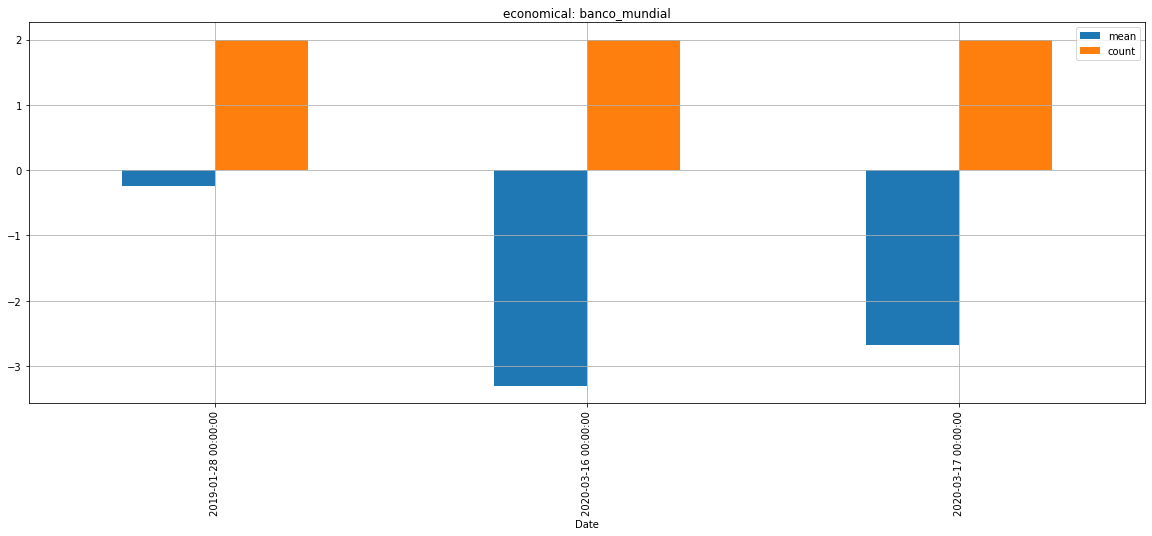

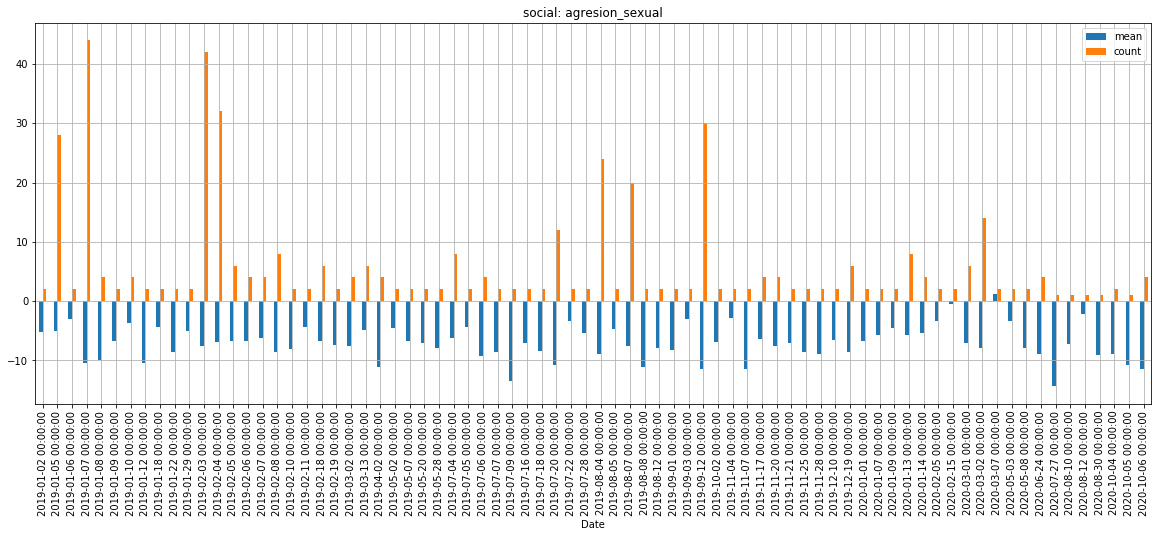

In [9]:
BQ_tables=[df_economical,df_social]
for df in BQ_tables:
    viz_min(df)

- Vemos que según las fuentes de Gdelt, sólo tenemos 3 noticias relacionadas con el **Banco Mundial**. 
- El sentimiento asociado a ambas noticias (que en Gdelt tṕipicamente va de -10 a +10), es negativa en ambas.

# Trabajando con el dataset de Google

- Voy a crear un dataset vació con las fechas de *df_google*.
- Crearé una columna para cada keyword del dataset. 
- Las filas serán el *trend_index* semanal de cada keyword.

**Info: Trend Index.**
Google Trends no te dice cuántas veces se ha buscado la palabra X en Google. En el intervalo de tiempo solicitado, el día que esa palabra ha tenido el máximo de búsquedas se le asocia el valor 100, y todo lo demás, en ese intervalo, queda normalizado por ese valor.

In [10]:
# dataset vacío
df_google_dates=pd.DataFrame()

# añadirle las fechas del dataset de google
df_google_dates["date"]=df_google["date"].unique()
df_google_dates["date"]=pd.to_datetime(df_google_dates["date"])
df_google_dates.sort_values(by=["date"],inplace=True)
df_google_dates.head()

,date
0,2019-01-06
1,2019-01-13
2,2019-01-20
3,2019-01-27
4,2019-02-03


In [11]:
# Comprobar que estamos en formato fecha
df_google_dates.date.dtypes

dtype('<M8[ns]')

In [12]:
# Crear una columna para cada elemento de la columna *keyword*:
keyword_list=(df_google["keyword"]).unique()
keyword_list.sort()

for k in keyword_list:
    df_google_dates[k]=df_google[(df_google['keyword'] == k)]["trend_index"].tolist()

df_google_dates.head()

,date,amazon,autonomo,ayuda alquiler,badi,banco alimentos,barometro,bildu,bullying,cabify,...,taxi,teletrabajo,tinder,uber,uber eats,videoconferencia,videollamada,vox,yoga,zoom
0,2019-01-06,59,47,38,38,5,32,3,24,20,...,42,2,56,27,10,2,2,35,50,5
1,2019-01-13,50,44,32,51,12,28,4,27,30,...,49,1,51,35,15,3,1,27,44,4
2,2019-01-20,44,41,20,38,13,31,2,25,100,...,100,2,50,100,9,3,2,16,41,3
3,2019-01-27,46,51,19,45,6,44,4,30,68,...,85,2,52,78,11,3,3,11,49,4
4,2019-02-03,48,47,21,32,7,58,5,24,45,...,67,1,50,40,11,3,2,13,48,4


In [13]:
# comprobación tonta de que no la hemos liado (no es suficiente, pero sí necesaria)
print(list(df_google_dates["zoom"][:10]),
      "<==>",
      df_google[df_google["keyword"]=="zoom"]["trend_index"].tolist()[:10],
      ", allright then"
     )

[5, 4, 3, 4, 4, 4, 4, 4, 3, 3] <==> [5, 4, 3, 4, 4, 4, 4, 4, 3, 3] , allright then


- El resultado se corresponde con lo que vimos en el preview (81 columnas + date)
- ¡Oh no! Vimos que teníamos *NaN* que ahora se han propagado por las columnas, ¿Qué hacemos?
    - Para cada columna, si hay NaN, vamos a cambiarlos por la media de los valores de esa columna

In [14]:
for c in df_google_dates.columns[1:]: 
    #date sabemos que está bien
    #print(df_google_dates[c].isna().sum())
    #print(df_google_dates[c].isnull().values.any())
    
    # rellenar NaN con la media de esa columna
    df_google_dates[c].fillna((df_google_dates[c].max()-df_google_dates[c].min())/len(df_google_dates[c]),
                             inplace=True)

- Cosas que me molan de aquí: 
    - Está hecho con Pandas.
    - He preferido quitarme los NaN una vez que tenía cada columna, para asociar al valor NaN la media correspondiente a su "grupo de keywords". Podria haberlo hecho anteriormente, pero hubiera sido quizás con una lambda function y un filtro más tedioso.

# Los datasets de BigQuery (noticias de The Gdelt).

Voy a:
- Crear una columna para cada keyword (como antes)
- Contar el número de veces al día que aparece una keyword.
- Calcular la media del sentimiento asociado por día de esa keyword.
- Crear una columna que tendrá el nombre de cada keyword, y en ella la nueva métrica será 
        occurrences · mean_daily_average
- Agruparé mis datos por semana, para mergearlos bien con el dataset de Google.

Multiplicar nº de veces que sale una keyword por el sentimiento asociado es la manera en la que he creado un *score* para keywords.

Voy a usar el mismísimo ejemplo que tengo en GitHub para explicar el proceso:

In [15]:
# keyword de ejemplo
df_political[df_political["political"]=="juicio"].head()

,political,Date,Sentiment
15773,juicio,2019-01-01,0.18
15774,juicio,2019-01-01,0.18
15784,juicio,2019-01-01,-6.08
15777,juicio,2019-01-01,-4.06
15778,juicio,2019-01-01,-4.06


In [16]:
# necesito medir la media de sentimiento por día
df_political[df_political["political"]=="juicio"].groupby("Date").mean().head()

,Sentiment
Date,
2019-01-01,-2.930000
2019-01-02,-3.986667
2019-01-03,-2.350000
2019-01-04,-4.822500
2019-01-05,-4.723333


In [17]:
# y contar el nº de veces que sale una keyword
df_political[df_political["political"]=="juicio"].groupby("Date").count().head()

,political,Sentiment
Date,,
2019-01-01,14,14
2019-01-02,18,18
2019-01-03,40,40
2019-01-04,16,16
2019-01-05,60,60


In [18]:
# vamos a usar bien las 2 juntas
df2=df_political[df_political["political"]=="juicio"].groupby(["Date"]).agg(['count','mean'])
# hay que eliminar el multiindex, que es terrible
df2.columns=df2.columns.droplevel(0)
df2.head()

,count,mean
Date,,
2019-01-01,14,-2.930000
2019-01-02,18,-3.986667
2019-01-03,40,-2.350000
2019-01-04,16,-4.822500
2019-01-05,60,-4.723333


In [19]:
# Para usar pandas.resample y agrupar por semana, necesitamos convertir la fecha en el index
df2.index = pd.to_datetime(df2.index)
df2 = df2.resample('W-SUN').mean() # amo resample de pandas
# y este es mi score
df2["score"]=df2["count"]*df2["mean"]
df2.head()

,count,mean,score
Date,,,
2019-01-06,27.666667,-4.097824,-113.373133
2019-01-13,68.857143,-6.805291,-468.592876
2019-01-20,36.857143,-6.178493,-227.721615
2019-01-27,37.714286,-5.767773,-217.527430
2019-02-03,36.000000,-4.441655,-159.899564


In [20]:
# Pues implementemos lo anterior, pero de forma generalizada en una función monstruosilla, pero útil
def creating_dataset(df,column):
    '''
    Desde los dataframes de BQ, crear nuevos dfs con las keywords y el score que me inventé, citado anteriormente
    Copio mi propia función literalmente 
    => https://github.com/albertovpd/automated_ML_regression/blob/master/script_explained.ipynb
    '''
    df["Date"]=pd.to_datetime(df["Date"])
    # list of new columns
    list_keywords=df[column].unique()
    # creating empty dataframe to append info
    df_final=pd.DataFrame()
    df_final["date"]=list(set(df["Date"]))
    
    for k in list_keywords:
        # creating a new dataframe for every keyword in the column, getting the occurrences of keyword and mean of sentiment
        df4=pd.DataFrame()
        df4=df[df[column]==k].groupby(["Date"]).agg(['count','mean'])
        # erase multiindex
        df4.columns=df4.columns.droplevel(0)
        # this will be our score, occurrences * mean 
        df4[k]=df4["count"]*df4["mean"]
        # date column to perform the join by it
        df4["date"]=df4.index
        df4.drop(columns=["count","mean"],inplace=True)
        # this is where we combine the empty dataset, every keyword in its place
        df_final=df_final.merge(df4,how='left', left_on='date', right_on='date')

    # resampling 
    # this is weird: transform date column in index, group by, then transform again index in column, to make the further join
    df_final.index=df_final["date"]
    df_final = df_final.resample('W-SUN').mean() #weekly totals
    df_final.sort_values(by="date", ascending=True, inplace=True)
    df_final["date"]=df_final.index
    df_final.reset_index(drop=True, inplace=True)
    
    
    return df_final

- A mejorar:
    - El pandas resample me trae de cabeza: Para usarlo, la fecha tiene que ser el index, pero a veces no pueden coexistir index-fecha y columna-fecha al realizar ciertas operaciones, así que tengo que convertir la columna fecha en index, borrar la columna fecha, y al final, convertir el índice en fecha de nuevo (porque quiero para las visualizaciones una columna fecha).

In [21]:
dfp = creating_dataset(df_political,"political")
dfp.head()

,juicio,seguridad_nacional,inestabilidad_politica,ejercito,vigilancia,protestas,rebelion,refugiados,terrorismo,corrupcion,extremismo,precio_petroleo,date
0,-111.880000,-30.555000,-7.770000,-20.473333,-31.525,-0.986667,-21.453333,-6.425000,-82.140000,-92.164000,-29.993333,NaN,2019-01-06
1,-485.394286,-5.313333,-23.500000,-31.360000,-67.150,-16.754286,-17.413333,-15.266667,-11.586667,-168.828571,-2.260000,NaN,2019-01-13
2,-232.251429,-3.220000,-36.120000,-23.700000,-49.556,-98.830000,-26.305000,NaN,-145.260000,-106.468571,-5.644000,3.72,2019-01-20
3,-233.122857,-16.080000,-24.146667,-25.508571,-14.530,-41.448571,-26.570000,1.276000,-34.084000,-106.342857,-4.226667,NaN,2019-01-27
4,-173.451429,-1.480000,-5.160000,-6.876667,-21.495,-35.362857,-28.106667,-20.310000,-24.512000,-112.497143,NaN,NaN,2019-02-03


In [22]:
dfs = creating_dataset(df_social,"social")
dfs.head()

,enfermedades_muy_infecciosas,inmigracion,vacunas,emergencia_sanitaria,agresion_sexual,ciencia,emprendimiento,precio_vivienda,energias_renovables,censura_en_medios,subsidios,racismo,date
0,-195.310000,-1.450000,-23.89,-88.380000,-52.646667,-6.680000,1.680,NaN,NaN,NaN,NaN,NaN,2019-01-06
1,-69.154286,0.896667,-11.04,-44.537143,-109.376000,-36.077143,5.300,-2.64,NaN,NaN,NaN,NaN,2019-01-13
2,-109.811429,3.912000,-5.89,-56.360000,-8.700000,-7.240000,NaN,NaN,NaN,NaN,NaN,NaN,2019-01-20
3,-101.220000,-6.730000,NaN,-28.240000,-17.140000,-26.273333,-3.932,NaN,NaN,NaN,NaN,NaN,2019-01-27
4,-120.577143,-79.540000,NaN,-56.934286,-164.080000,-8.630000,5.640,0.34,-2.78,1.74,NaN,NaN,2019-02-03


In [23]:
dfe = creating_dataset(df_economical,"economical")
dfe.head()

,incertidumbre_economica,pobreza,stock_market,macroeconomia_deuda_y_vulnerabilidad,desempleo,libre_comercio,job_quality_&_labor_market_performance,inflacion_economica,quiebra_economica,precio_petroleo,crecimiento_economico,banco_mundial,finanzas_y_bancos,prosperidad_economica_y_finanzas,date
0,-631.063333,-41.553333,-19.043333,-37.705,-41.995000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-01-06
1,-750.242857,-66.840000,-14.948571,-7.460,-5.933333,-17.82,-9.820000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-01-13
2,-791.151429,-23.345714,-7.531429,-7.760,-35.166667,NaN,-2.368000,7.44,-11.610000,3.72,NaN,NaN,NaN,NaN,2019-01-20
3,-770.017143,-12.205714,-16.442857,-21.000,-14.246667,NaN,-10.792000,NaN,0.780000,NaN,1.99,NaN,NaN,NaN,2019-01-27
4,-696.837143,-41.560000,-12.111429,-29.860,-11.875000,NaN,-3.333333,NaN,-8.773333,NaN,NaN,-0.5,NaN,NaN,2019-02-03


- Hay muchos NaN: Todo OK. Nos ocuparemos de todos a la vez más adelante.

# Mergear los 4 datasets

- Crear un df vacío.
- Insertar las fechas correspondientes a todos los dfs sin duplicar.
- Usar las fechas como key para mergear con todos los datasets.

In [24]:
# df final
date1 = '2019-01-01' # inicio de las requests
#date2 = datetime.now().date() #esto es lo que uso en mi pipeline en GCP
date2="2020-10-18"
mydates = pd.date_range(date1, date2, freq="W").tolist()
df_final=pd.DataFrame()
df_final["date"]=mydates
df_final['date']=pd.to_datetime(df_final["date"])
df_final.head()

,date
0,2019-01-06
1,2019-01-13
2,2019-01-20
3,2019-01-27
4,2019-02-03


In [25]:
datasets = [ dfp, dfe, dfs,df_google_dates] # los df ya procesados
for d in datasets:
    df_final=df_final.merge(d,how='left', left_on="date", right_on="date")
df_final=df_final.fillna(0) # los nan de los que hablábamos
df_final.head()

,date,juicio,seguridad_nacional,inestabilidad_politica,ejercito,vigilancia,protestas,rebelion,refugiados_x,terrorismo,...,taxi,teletrabajo,tinder,uber,uber eats,videoconferencia,videollamada,vox,yoga,zoom
0,2019-01-06,-111.880000,-30.555000,-7.770000,-20.473333,-31.525,-0.986667,-21.453333,-6.425000,-82.140000,...,42,2,56,27,10,2,2,35,50,5
1,2019-01-13,-485.394286,-5.313333,-23.500000,-31.360000,-67.150,-16.754286,-17.413333,-15.266667,-11.586667,...,49,1,51,35,15,3,1,27,44,4
2,2019-01-20,-232.251429,-3.220000,-36.120000,-23.700000,-49.556,-98.830000,-26.305000,0.000000,-145.260000,...,100,2,50,100,9,3,2,16,41,3
3,2019-01-27,-233.122857,-16.080000,-24.146667,-25.508571,-14.530,-41.448571,-26.570000,1.276000,-34.084000,...,85,2,52,78,11,3,3,11,49,4
4,2019-02-03,-173.451429,-1.480000,-5.160000,-6.876667,-21.495,-35.362857,-28.106667,-20.310000,-24.512000,...,67,1,50,40,11,3,2,13,48,4


# Correlaciones. 

In [26]:
# Me alivia saber que Pandas piensa que la inestabilidad política y el ejército no están relacionados
# en España.
df_final.corr()

,juicio,seguridad_nacional,inestabilidad_politica,ejercito,vigilancia,protestas,rebelion,refugiados_x,terrorismo,corrupcion_x,...,taxi,teletrabajo,tinder,uber,uber eats,videoconferencia,videollamada,vox,yoga,zoom
juicio,1.000000,-0.104367,0.145688,0.138250,0.276912,0.123579,0.283107,0.031675,0.270288,0.503528,...,-0.516791,0.444598,0.513388,-0.076853,0.499530,0.243973,0.206132,-0.072141,0.177751,0.335915
seguridad_nacional,-0.104367,1.000000,0.177923,0.359744,0.176559,0.111527,-0.020370,0.034394,-0.007592,0.015970,...,0.114407,-0.056040,0.105872,0.120174,0.039660,-0.129408,-0.134831,-0.142918,-0.165214,-0.174359
inestabilidad_politica,0.145688,0.177923,1.000000,-0.025634,0.013028,0.728044,0.179663,-0.098623,0.211260,0.077777,...,0.016835,0.089363,0.126423,-0.095668,-0.026985,0.040031,0.037385,-0.205000,0.007918,0.033535
ejercito,0.138250,0.359744,-0.025634,1.000000,0.205697,-0.021815,-0.088454,0.129204,-0.041268,-0.019165,...,0.097124,-0.091932,0.125408,0.227747,0.133462,-0.401903,-0.513607,0.076063,-0.524102,-0.535630
vigilancia,0.276912,0.176559,0.013028,0.205697,1.000000,0.208453,0.207066,0.067318,0.163285,0.200689,...,-0.107418,0.120138,0.249665,0.037419,0.234900,-0.052958,-0.042692,-0.061761,-0.084063,0.002502
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
videoconferencia,0.243973,-0.129408,0.040031,-0.401903,-0.052958,0.097561,0.096902,-0.123639,0.212152,0.201230,...,-0.590266,0.691207,-0.028657,-0.362025,0.210836,1.000000,0.935246,-0.100760,0.884381,0.876998
videollamada,0.206132,-0.134831,0.037385,-0.513607,-0.042692,0.085598,0.086577,-0.200496,0.186181,0.206615,...,-0.506815,0.543127,-0.072578,-0.356450,0.129438,0.935246,1.000000,-0.098755,0.912215,0.892057
vox,-0.072141,-0.142918,-0.205000,0.076063,-0.061761,-0.111419,0.024647,-0.043521,-0.059102,-0.141487,...,-0.012597,-0.193453,-0.343628,-0.063005,-0.202307,-0.100760,-0.098755,1.000000,-0.109075,-0.118819
yoga,0.177751,-0.165214,0.007918,-0.524102,-0.084063,0.039671,0.015681,-0.146471,0.133952,0.135521,...,-0.496147,0.452800,-0.147412,-0.384847,0.034017,0.884381,0.912215,-0.109075,1.000000,0.877967


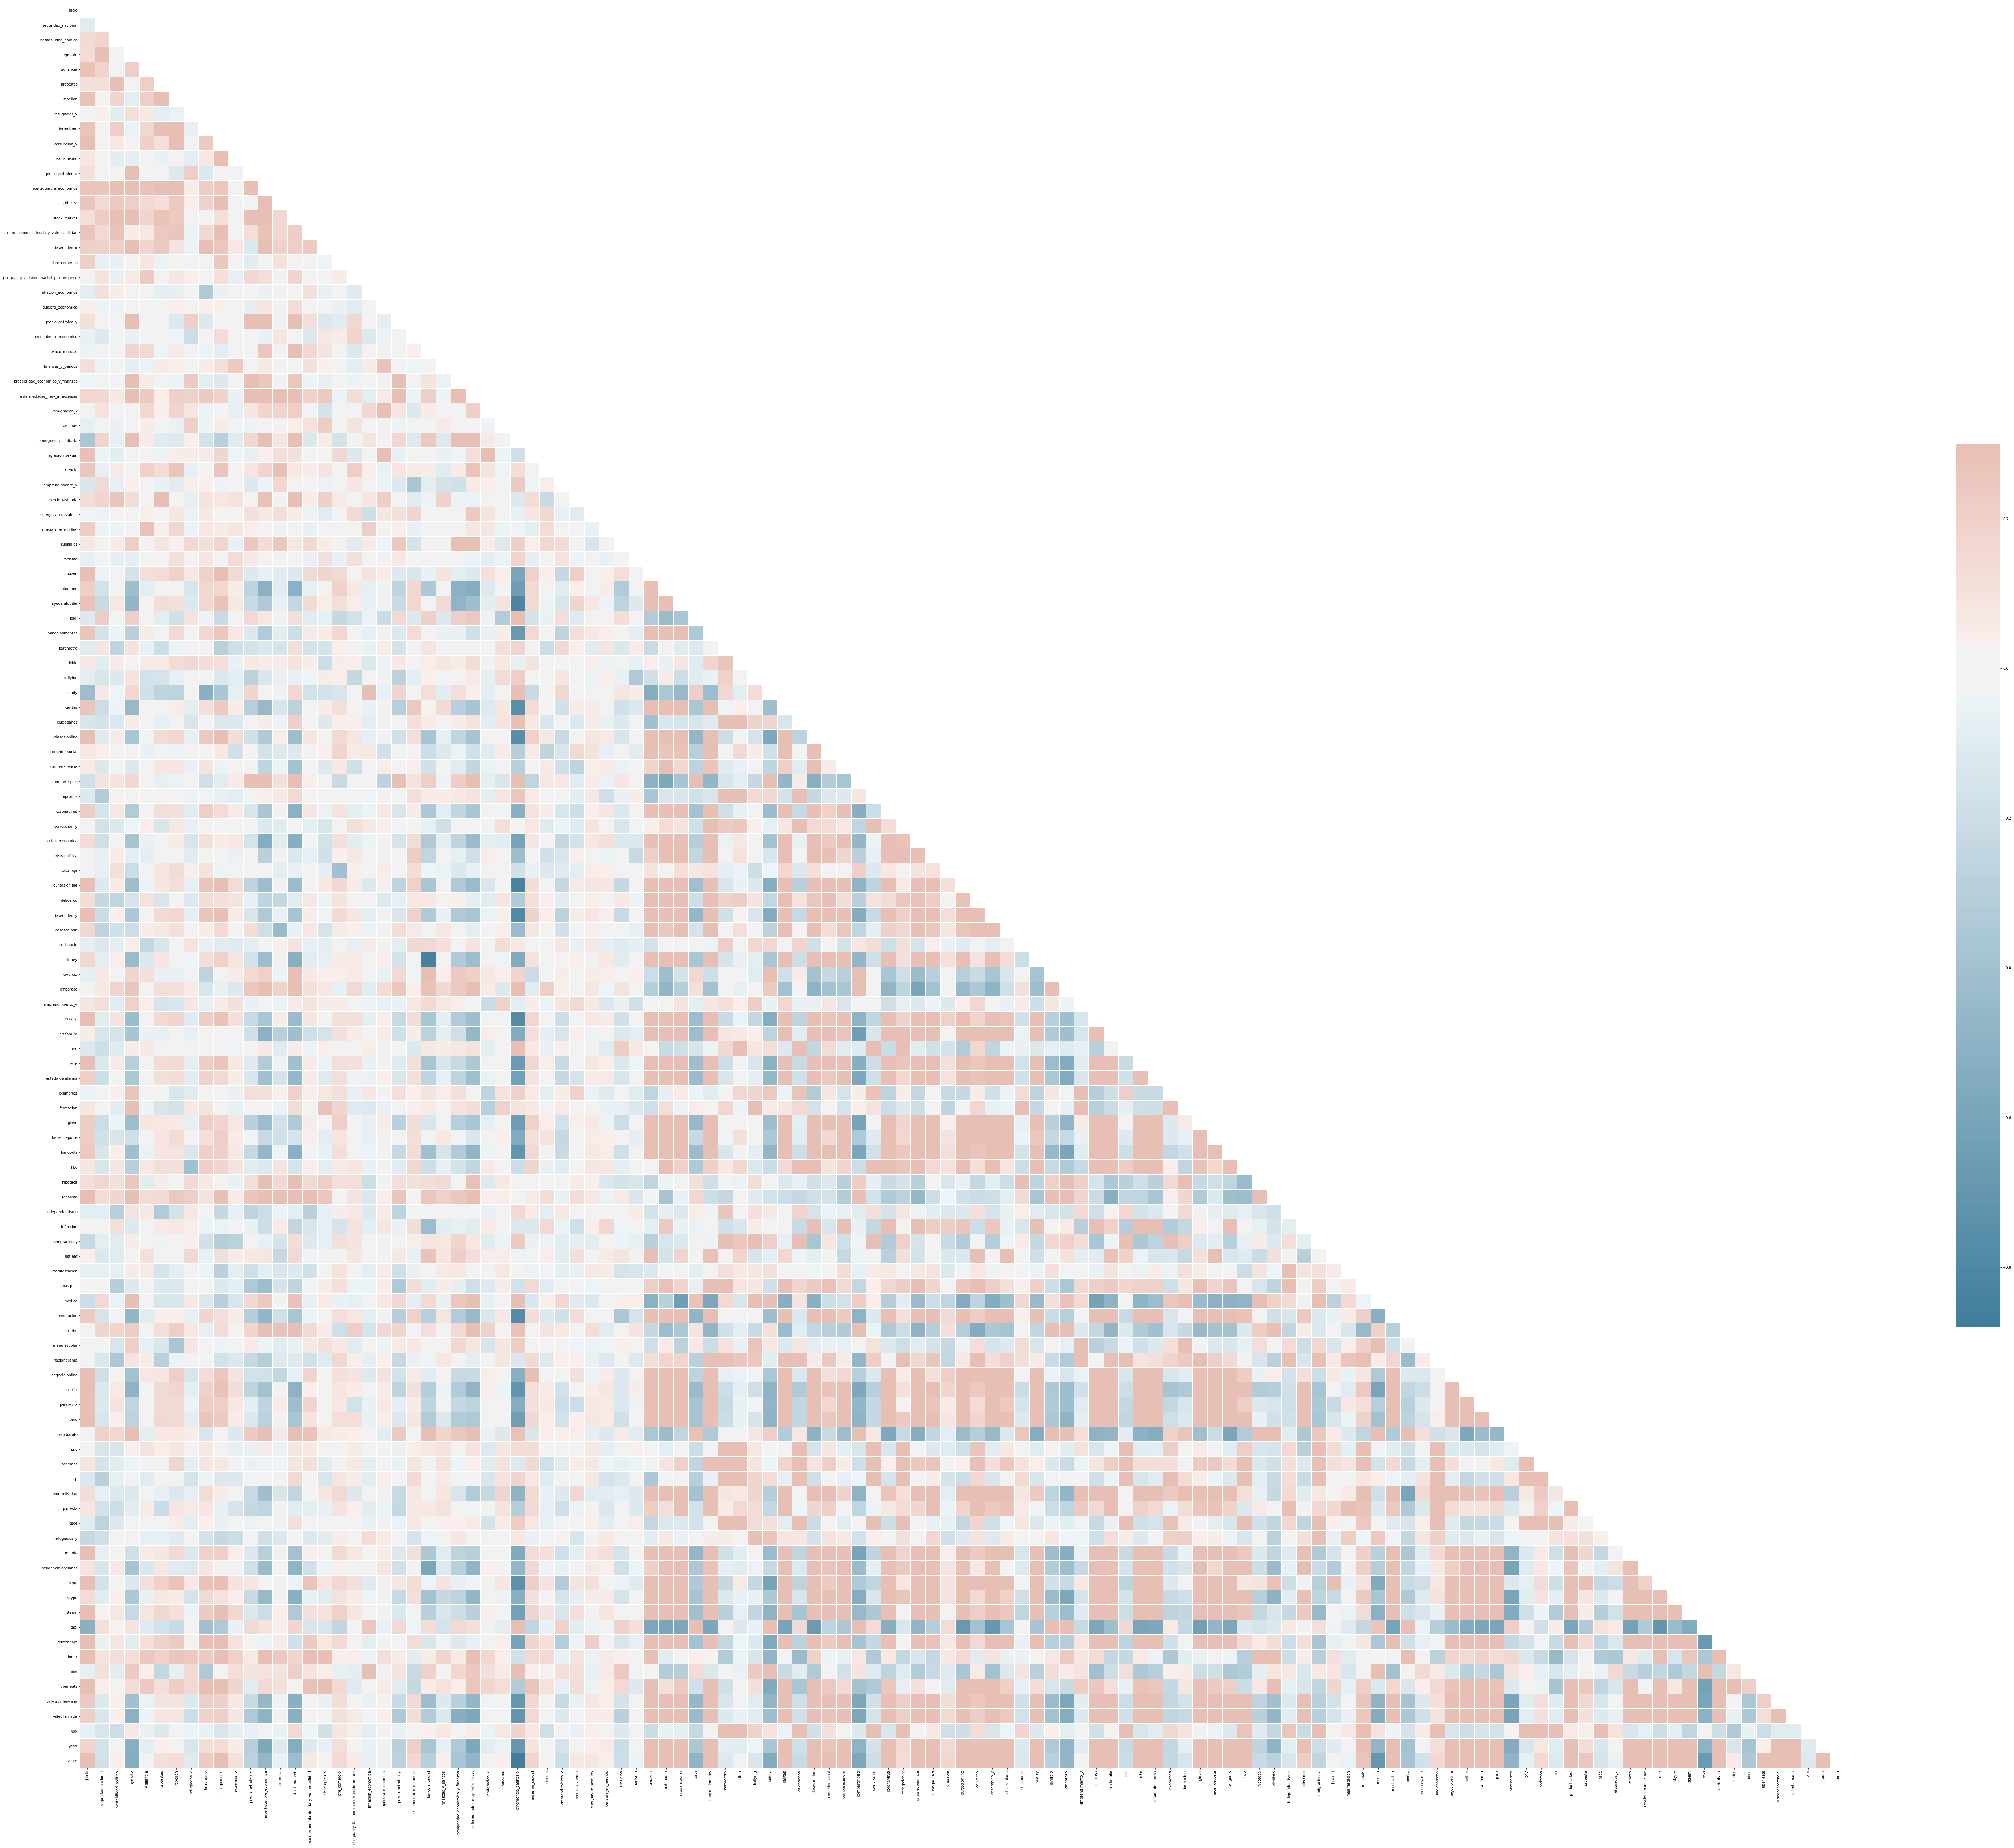

In [27]:
# Huge correlation map
# https://seaborn.pydata.org/examples/many_pairwise_correlations.html

# Generate a mask for the upper triangle
corr=df_final.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(110, 90))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

- Podemos... Agrandar la foto para buscar correlaciones visuales... O podemos usar un RFE (Recursive Feature Elimination) que seleccione las mejores 15 columnas para realizar las inferencias que queremos. Profundizaremos en este área más adelante.

# Eliminar outliers

In [28]:
def remove_outliers(df):
    '''
    Quitando outliers muy, muy outliers
    '''
    columns=list(df.columns)
    columns.remove("date")
    for c in columns: # Para cada columna hallamos su cuantil
        q_low= df[c].quantile(0.01)
        q_high=df[c].quantile(0.99)
        
        # Y en esa columna eliminamos los outliers
        df_filtered= df[(df[c] < q_high) & (df[c] > q_low)]
        return df_filtered

In [29]:
df_final.shape

(94, 120)

In [30]:
df_final=remove_outliers(df_final)

In [31]:
df_final.shape

(92, 120)

- Hemos eliminado el 2% de nuestras filas para mejorar el algoritmo

# Preparando el df para ML


- Mi target es la columna desempleo, voy a crear un nuevo df con esta columna y la columna date.
- Voy a eliminar desempleo del df principal.
- Voy a avanzar 4 semanas las fechas del df principal.
- Volveré a insertar la columna de desempleo, con sus antiguas fechas (todo estará desplazado hacia adelante en el tiempo, pero *desempleo* seguirá en su fecha correcta).

Actualmente desconozco si existe un proceso menos redundante para realizar esta labor. Vale la pena investigar al respecto.

In [32]:
# cambiar nombre del target
df_final.rename(columns={'desempleo_y':"unemployment"}, inplace=True)

In [33]:
df_unemployment=pd.DataFrame(df_final[["date", "unemployment"]])
df_final.drop(columns="unemployment", inplace=True)
df_final.head()

,date,juicio,seguridad_nacional,inestabilidad_politica,ejercito,vigilancia,protestas,rebelion,refugiados_x,terrorismo,...,taxi,teletrabajo,tinder,uber,uber eats,videoconferencia,videollamada,vox,yoga,zoom
0,2019-01-06,-111.880000,-30.555,-7.770000,-20.473333,-31.525,-0.986667,-21.453333,-6.425,-82.140,...,42,2,56,27,10,2,2,35,50,5
2,2019-01-20,-232.251429,-3.220,-36.120000,-23.700000,-49.556,-98.830000,-26.305000,0.000,-145.260,...,100,2,50,100,9,3,2,16,41,3
3,2019-01-27,-233.122857,-16.080,-24.146667,-25.508571,-14.530,-41.448571,-26.570000,1.276,-34.084,...,85,2,52,78,11,3,3,11,49,4
4,2019-02-03,-173.451429,-1.480,-5.160000,-6.876667,-21.495,-35.362857,-28.106667,-20.310,-24.512,...,67,1,50,40,11,3,2,13,48,4
5,2019-02-10,-377.391429,-2.430,-55.030000,-43.380000,-18.320,-41.700000,-27.230000,-7.830,-68.092,...,44,1,63,30,14,3,1,19,47,4


In [34]:
df_final["date"]=df_final["date"].apply(lambda x: x+timedelta(weeks=4))
df_final.head()

,date,juicio,seguridad_nacional,inestabilidad_politica,ejercito,vigilancia,protestas,rebelion,refugiados_x,terrorismo,...,taxi,teletrabajo,tinder,uber,uber eats,videoconferencia,videollamada,vox,yoga,zoom
0,2019-02-03,-111.880000,-30.555,-7.770000,-20.473333,-31.525,-0.986667,-21.453333,-6.425,-82.140,...,42,2,56,27,10,2,2,35,50,5
2,2019-02-17,-232.251429,-3.220,-36.120000,-23.700000,-49.556,-98.830000,-26.305000,0.000,-145.260,...,100,2,50,100,9,3,2,16,41,3
3,2019-02-24,-233.122857,-16.080,-24.146667,-25.508571,-14.530,-41.448571,-26.570000,1.276,-34.084,...,85,2,52,78,11,3,3,11,49,4
4,2019-03-03,-173.451429,-1.480,-5.160000,-6.876667,-21.495,-35.362857,-28.106667,-20.310,-24.512,...,67,1,50,40,11,3,2,13,48,4
5,2019-03-10,-377.391429,-2.430,-55.030000,-43.380000,-18.320,-41.700000,-27.230000,-7.830,-68.092,...,44,1,63,30,14,3,1,19,47,4


In [36]:
# Volvemos a meter el target en el dataset
df=pd.merge(df_final,df_unemployment,how='outer', on=["date"],suffixes=(None,None))
df.sort_values(by=["date"],inplace=True)
df=df.fillna(0)

In [37]:
# Podemos comprobar que las últimas 4 filas de la última columna están por rellenar
df.tail(8)

,date,juicio,seguridad_nacional,inestabilidad_politica,ejercito,vigilancia,protestas,rebelion,refugiados_x,terrorismo,...,teletrabajo,tinder,uber,uber eats,videoconferencia,videollamada,vox,yoga,zoom,unemployment
84,2020-09-27,-30.982857,-4.520000,-11.380,-10.444286,-15.118000,-4.710000,-25.615000,-0.120000,-1.433333,...,40.0,95.0,41.0,66.0,12.0,7.0,7.0,47.0,17.0,41.0
85,2020-10-04,-85.438571,-9.435000,-5.005,-15.531667,-10.762857,-19.121429,-0.300000,-4.150000,-18.955000,...,27.0,98.0,40.0,67.0,18.0,7.0,8.0,48.0,18.0,39.0
86,2020-10-11,-65.444286,1.770000,-14.050,-7.958571,-11.210000,-5.543333,-5.460000,-4.076667,-14.833333,...,36.0,92.0,39.0,68.0,14.0,4.0,8.0,50.0,19.0,30.0
87,2020-10-18,-44.481429,-2.000000,-7.480,-17.352857,-4.056667,-7.955000,-4.933333,-3.205000,-3.300000,...,100.0,88.0,45.0,75.0,17.0,7.0,8.0,47.0,22.0,27.0
88,2020-10-25,-57.642857,-3.656667,0.000,-8.762857,-18.855714,-10.885714,-2.670000,-3.600000,-7.586000,...,43.0,88.0,48.0,90.0,17.0,8.0,10.0,46.0,20.0,0.0
89,2020-11-01,-73.910000,-11.045000,-39.070,-23.806667,-8.550000,-15.368000,0.000000,-3.880000,-4.770000,...,24.0,82.0,46.0,91.0,10.0,5.0,8.0,45.0,20.0,0.0
90,2020-11-08,-39.984286,0.000000,-14.970,-7.471667,-4.736000,-6.241667,-1.250000,-4.330000,-3.846667,...,38.0,90.0,47.0,100.0,8.0,7.0,11.0,42.0,18.0,0.0
91,2020-11-15,-103.931667,-1.650000,-3.990,-7.702857,-12.390000,-8.295000,-4.800000,-0.665000,-5.055000,...,25.0,82.0,47.0,99.0,13.0,7.0,11.0,39.0,21.0,0.0


In [38]:
df.reset_index(drop=True,inplace=True)
# vamos a eliminar las primeras 4 columnas, que nos van a estropear el ajuste de la regresión (son 0 para mi X)
df.drop([0,1,2,3], inplace=True)

# Normalizar

- Como dijimos, tenemos 4 datasets, y el de Google, tiene unas métricas de 0 a 100, completamente diferente al resto, cuyas  métricas me inventé y eran occurrencias * media del sentimiento.
- Leí que para mezclar datasets con diferentes métricas estaba bien usar definir la normalización como:
        
$\sum_{i=1}^{n} ( x_i - \hat{x}) / (x_{max} - x_{min})$

In [40]:
# Normalizar todo menos mi target
X = df.drop(columns=["date","unemployment"]) 
X = X.apply(lambda x: (x - np.mean(x)) / (np.max(x) - np.min(x)))
target=df["unemployment"]

In [41]:
X.head()

,juicio,seguridad_nacional,inestabilidad_politica,ejercito,vigilancia,protestas,rebelion,refugiados_x,terrorismo,corrupcion_x,...,taxi,teletrabajo,tinder,uber,uber eats,videoconferencia,videollamada,vox,yoga,zoom
4,0.373032,0.104568,0.067181,0.186993,0.221750,0.083403,0.137483,0.060392,0.151890,0.331535,...,-0.460645,-0.140753,-0.672258,-0.409032,-0.454409,-0.108602,-0.089032,-0.164086,-0.464194,-0.143656
5,-0.139946,0.060558,-0.047560,0.037968,-0.345361,-0.295825,-0.093226,0.060392,-0.848110,-0.065300,...,0.539355,-0.120753,-0.172258,0.590968,-0.364409,-0.078602,-0.069032,-0.004086,-0.054194,-0.113656
6,-0.141871,-0.115209,-0.009525,0.026595,0.055471,-0.075642,-0.095550,0.071671,-0.082751,-0.064831,...,0.389355,-0.120753,-0.152258,0.370968,-0.344409,-0.078602,-0.059032,-0.054086,0.025806,-0.103656
7,-0.010073,0.084340,0.050789,0.143752,-0.024236,-0.052290,-0.109027,-0.119136,-0.016855,-0.087770,...,0.209355,-0.130753,-0.172258,-0.009032,-0.344409,-0.078602,-0.069032,-0.034086,0.015806,-0.103656
8,-0.460519,0.071356,-0.107630,-0.085780,0.012099,-0.076607,-0.101338,-0.008820,-0.316869,-0.668465,...,-0.020645,-0.130753,-0.042258,-0.109032,-0.314409,-0.078602,-0.079032,0.025914,0.005806,-0.103656


In [42]:
target.head()

4    23.0
5    23.0
6    20.0
7    27.0
8    30.0
Name: unemployment, dtype: float64

# Machine Learning

- Realmente lo que quiero inferir son las últimas 4 filas del dataset, para la columna *unemployment*.

In [44]:
# entreno con todo menos las 4 últimas filas
X_train=X.iloc[:-4]
target_train=target.iloc[:-4]

# lo que quiero hallar
X_test=X.iloc[-4:]
target_test=target.iloc[-4:]

In [45]:
# alpha=1 es como una regresión lineal. Lo bueno/malo de Lasso es que hace 0 todos los coefs que no son importantes
regression = Lasso(alpha=0.1)

# neg mean squared error: la de toda la vida, lo que pasa es que jugamos con la representación positiva
# RFE = recursive feature elimination, va probando hasta coger las 15 que provoquen un menor MSE
rfecv = RFECV(estimator=regression, step=1, min_features_to_select=15, cv=5,scoring='neg_mean_squared_error')
rfecv.fit(X_train, target_train)


RFECV(cv=5,
      estimator=Lasso(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=1000,
                      normalize=False, positive=False, precompute=False,
                      random_state=None, selection='cyclic', tol=0.0001,
                      warm_start=False),
      min_features_to_select=15, n_jobs=None, scoring='neg_mean_squared_error',
      step=1, verbose=0)

In [46]:
# Mis inferencias
rfecv.predict(X_test)

array([32.57259042, 39.40895797, 37.54741288, 35.13699688])

In [47]:
# Mi RMSE (requisito que dije que cumpliría)
rfecv.score(X_train, target_train)

0.8065027859503469

- Aquí termina mi proyecto de limpieza y procesamiento de dataframes. Espero que haya sido interesante.

# Resultados.

- Los resultados de mi proyecto personal pueden consultarse aquí => https://datastudio.google.com/u/1/reporting/e171bbe8-0db8-49bb-b1d6-86cb4f16acdf/page/ceonB

- Sobre el RMSE: No es un buen ajuste, sólo quería sacarlo y jugar un poco con los datos. Al final he ido modificando poco a poco mi proyecto personal hasta tener métricas más óptimas.

## Logros:

- Refactorizar, un poquito, un proyecto personal.
- Intentar explicar de forma detallada los pasos.
- Coger soltura con Pandas y Numpy, principalmente con los filtros de Pandas, que siempre se me han atragantado.
- Intentar usar las funciones propias de Pandas en la medida de lo posible (como en las visualizaciones)
